<h1>Proyecto Sprint 13: Customer classification based on clustering </h1>

<h3>Objectives</h3>

<li>PRedict the probability of lossing a customer on the following month</li>
<li>Identify characteristics of typical users</li>
<li>Analyze the factors that impact customer lose</li>
<li>Elabborate conclusions and recomendations</li>


<h2>Preliminary Data Analysis EDA</h2>

library import

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [5]:
#data import

data=pd.read_csv('gym_churn_us.csv')
print(data.head())
data.shape
display(data.info())


   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0  

None

In [6]:
#search for dupplicated values
print(data.duplicated().sum())

0


In [7]:
#data exploration with descrie method
print(data.describe())

            gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.00

It is apparent that the dataset contains no missing values or duplicate rows. Some features have already been pre-processed so they can be fed directly into the machine-learning algorithm. The target variable is imbalanced: roughly 25 % of the records correspond to clients who left the gym. Preliminary data also show a small minority of highly committed customers who purchase long-term memberships and have been registered for many months. The most common pattern is to buy a one-month membership at a time; group visits are rare, and most users are between 27 and 31 years old. An important point is that there is a sufficiently large number of observations to train a machine-learning prediction model. We now proceed to the grouped (clustered) analysis.

In [8]:
# average parameters comparison for the customers who remained (0) and the customers who left (1)
 
clients_leave=data.groupby('Churn').mean()
print(clients_leave)

         gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.0

In [9]:
#Characteristics visualization in historgams for the clients who left and those who stayed
clients_left=data[data['Churn']==1]
clients_stay=data[data['Churn']==0]

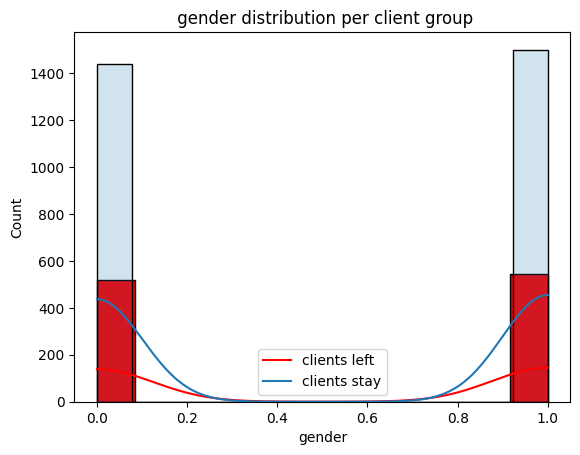

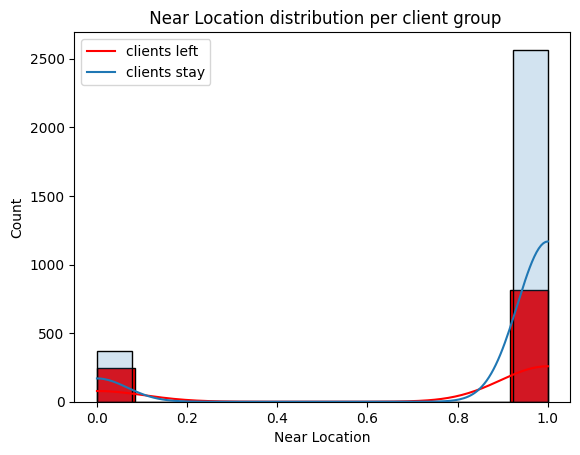

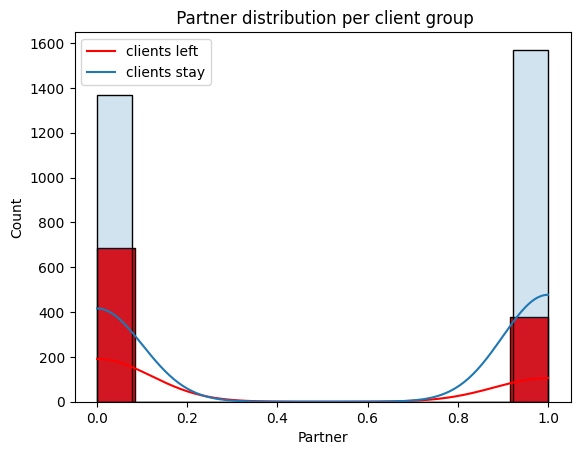

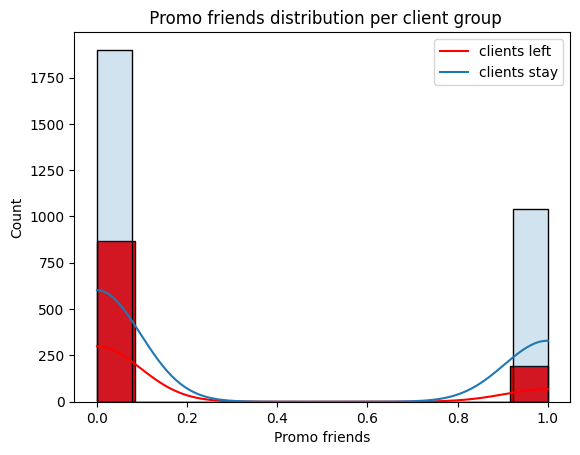

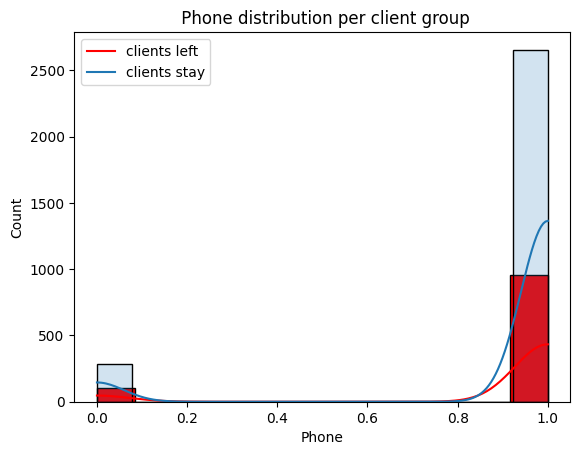

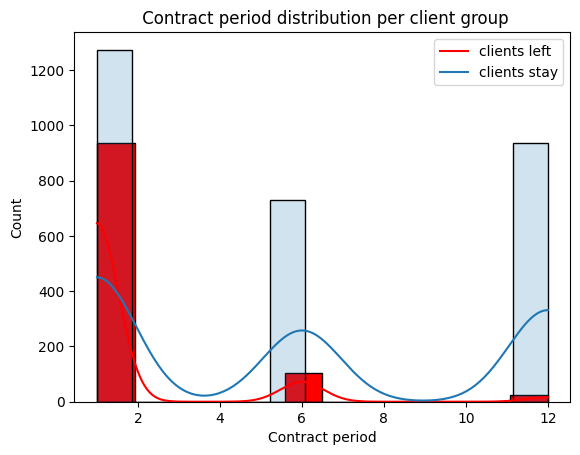

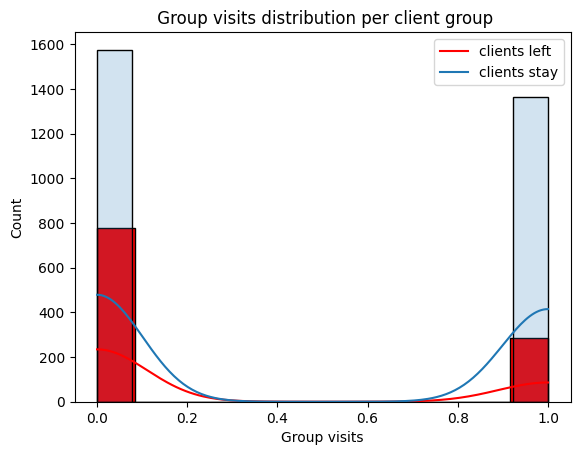

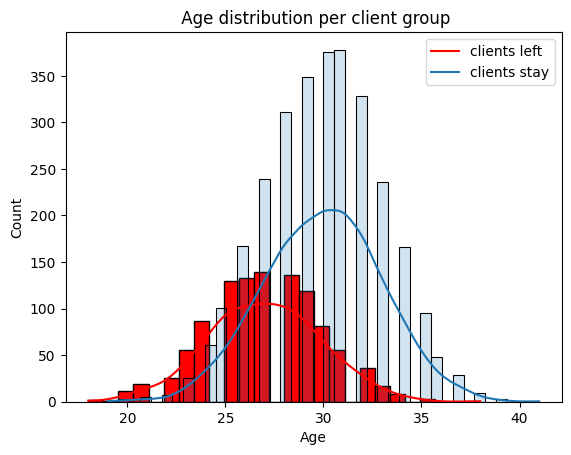

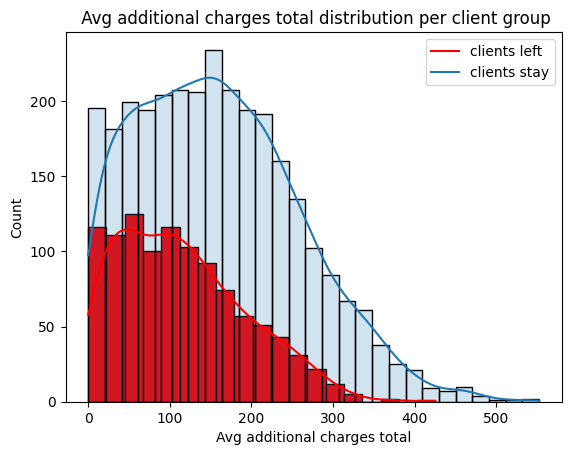

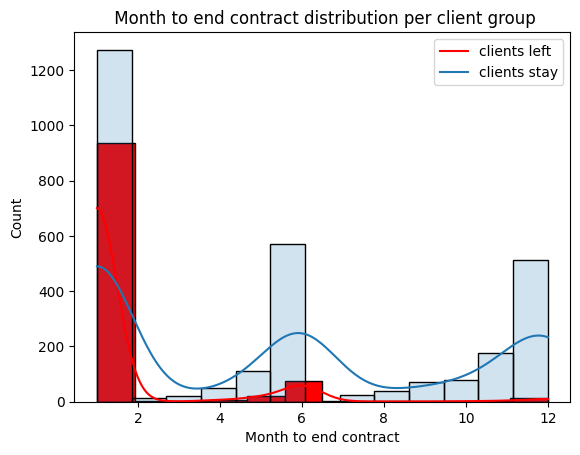

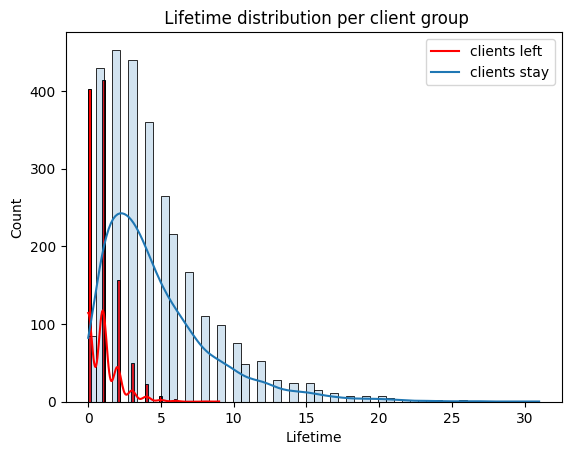

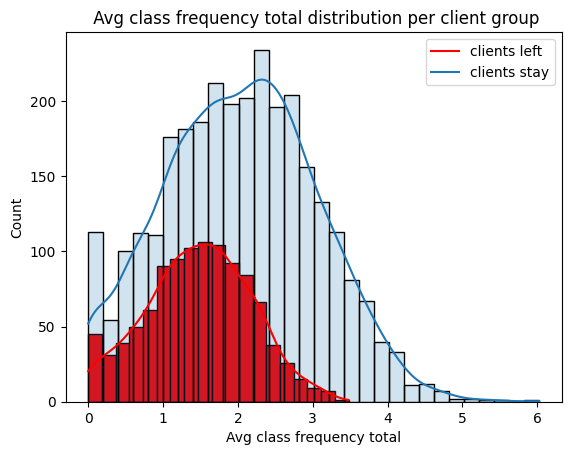

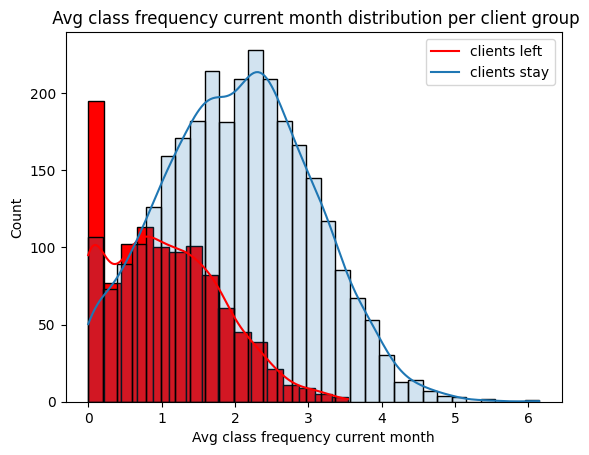

In [10]:
for i in clients_leave.columns:
    sns.histplot(clients_left[i],kde=True, alpha=1, color='red')
    sns.histplot(clients_stay[i],kde=True, alpha=0.2)
    plt.legend(['clients left', 'clients stay'])
    i=i.replace('_',' ')
    plt.title(f' {i} distribution per client group')
    plt.xlabel(i)
    plt.show()

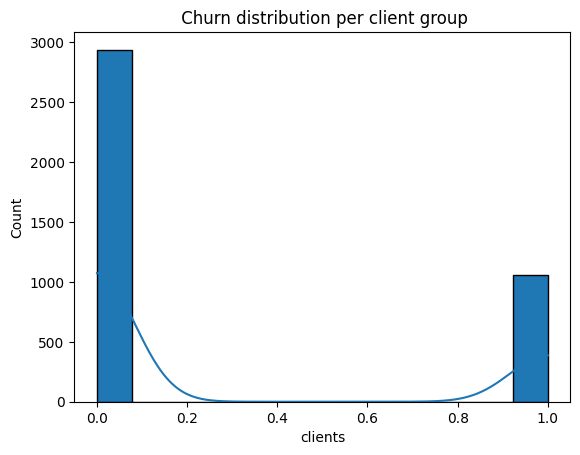

In [11]:
sns.histplot(data['Churn'], kde=True, alpha=1)
plt.title(' Churn distribution per client group')
plt.xlabel('clients')
plt.show()

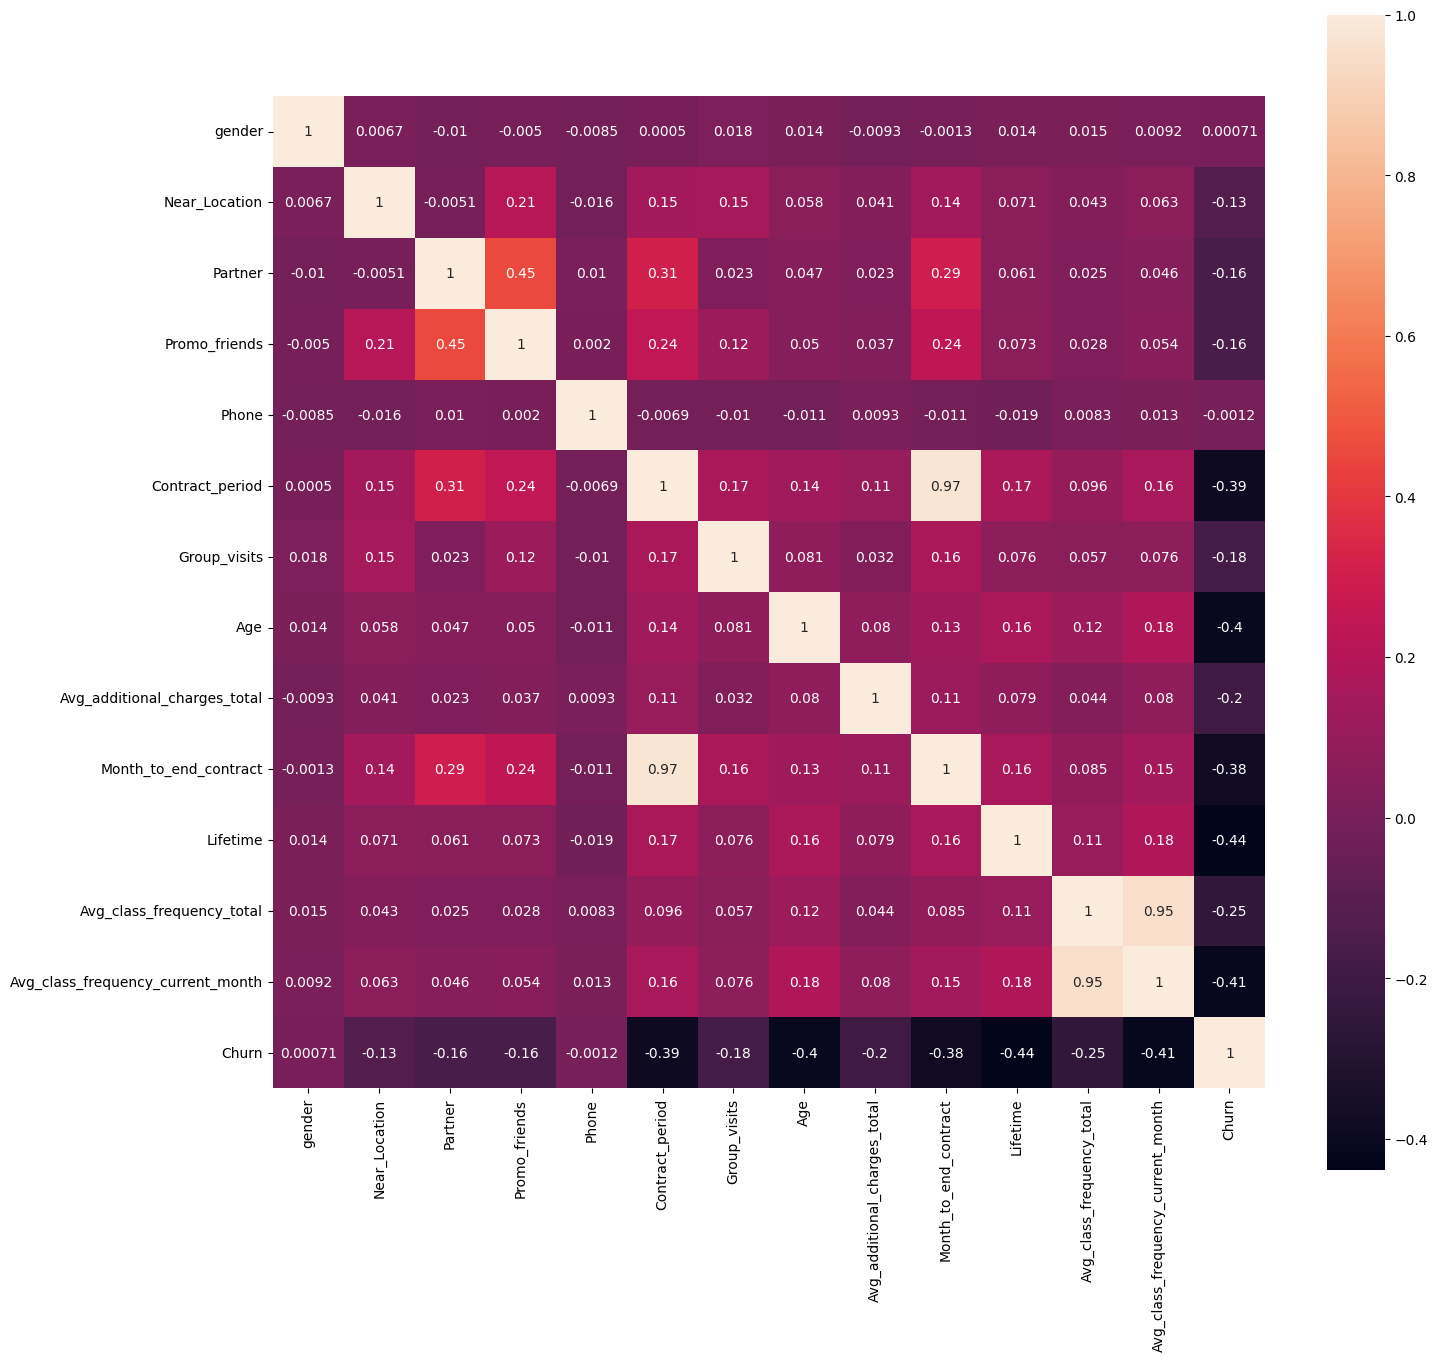

In [12]:
# Correlation matrix to identify relevant characteristics

corr_m=data.corr()
plt.figure(figsize=(16,15))
sns.heatmap(corr_m, square=True, annot=True)
plt.show()

Preliminary analysis suggests that some features are more strongly linked to customers who leave than others. In particular, contract type, the final month of the contract, participation in group visits, use of “bring-a-friend” promotions, having a workout partner, and location appear influential. Other attributes—such as gender and phone number—seem only weakly related.

The correlation matrix also shows several features with negative coefficients, meaning that higher values of those features reduce the likelihood of churn. We will now move on to the automated analysis stage: building a model to predict whether a customer will leave, after eliminating highly correlated variables.



<h2>Model development based on machine learning</h2>

Data preparation for the model

In [13]:
#Separation of user characteristics from the target variable

X=data.drop(['Churn','Month_to_end_contract','Avg_class_frequency_current_month'],axis=1) #se remueve variable correlacionada para evitar error por sobreajuste
y=data['Churn']

print(X.head())
print()
print(y.head())

   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Lifetime  \
0             1   29                     14.227470         3   
1             1   31                    113.202938         7   
2             0   28                    129.448479         2   
3             1   33                     62.669863         2   
4             0   26                    198.362265         3   

   Avg_class_frequency_total  
0                   0.020398  
1                   1.922936  
2                   1.859098  
3                   3.205633  
4  

In [14]:
#Data separation into training and test sets

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(3200, 11)
(800, 11)


In [15]:
#Characteristics scalation

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 
X_test_st = scaler.transform(X_test)

In [16]:
#Model training for binary classification

model = LogisticRegression(random_state=0)

model.fit(X_train,y_train)

predictions= model.predict(X_test)

#evaluación de la prediccion
acc = accuracy_score(y_test, predictions)
precision = precision_score (y_test, predictions)
recall = recall_score (y_test, predictions)
print('exactitud {}, precision {}, recall {}'.format(acc,precision, recall))

exactitud 0.875, precision 0.7378640776699029, recall 0.7676767676767676


C:\Users\ngutierr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# addition of model iterations to enhance model convergence

model = LogisticRegression(max_iter=1000, random_state=0)

model.fit(X_train,y_train)

predictions= model.predict(X_test)

#evaluación de la prediccion
acc = accuracy_score(y_test, predictions)
precision = precision_score (y_test, predictions)
recall = recall_score (y_test, predictions)
print('exactitud {}, precision {}, recall {}'.format(acc,precision, recall))

exactitud 0.8975, precision 0.7843137254901961, recall 0.8080808080808081


In [18]:
#training a random forest model for customer classification

rf_model = RandomForestClassifier(n_estimators=100, random_state = 0)
rf_model.fit(X_train_st,y_train)
rf_predictions = rf_model.predict(X_test_st)

acc = accuracy_score(y_test, rf_predictions)
precision = precision_score (y_test, rf_predictions)
recall = recall_score (y_test, rf_predictions)
print('exactitud {}, precision {}, recall {}'.format(acc,precision, recall))

exactitud 0.89, precision 0.7864583333333334, recall 0.7626262626262627


In [19]:
#training a random forrest model with all the characteristics

X1=data.drop(['Churn'],axis=1) 
y1=data['Churn']
X_train,X_test,y_train,y_test=train_test_split(X1,y1,test_size=0.2, random_state=0)

scaler = StandardScaler()

X_train_st = scaler.fit_transform(X_train) 
X_test_st = scaler.transform(X_test)
rf_model2 = RandomForestClassifier(n_estimators=100, random_state = 0)
rf_model2.fit(X_train_st,y_train)
rf_predictions2 = rf_model2.predict(X_test_st)

acc = accuracy_score(y_test, rf_predictions2)
precision = precision_score (y_test, rf_predictions2)
recall = recall_score (y_test, rf_predictions2)
print('exactitud {}, precision {}, recall {}'.format(acc,precision, recall))

exactitud 0.915, precision 0.8385416666666666, recall 0.8131313131313131


In [20]:
#analysis of model's coefficients

importances = rf_model2.feature_importances_

#print('Coeficientes del modelo bosque aleatorio: ', importances)

coef=pd.DataFrame([X1.columns,importances],index=['caracteristica','valor'])
coef2=coef.T

print(coef2.sort_values(by=['valor'],ascending=False))

                       caracteristica     valor
10                           Lifetime  0.276499
12  Avg_class_frequency_current_month   0.18017
11          Avg_class_frequency_total  0.129883
7                                 Age  0.119129
8        Avg_additional_charges_total  0.091473
9               Month_to_end_contract  0.068855
5                     Contract_period  0.065964
6                        Group_visits  0.015652
0                              gender  0.012425
2                             Partner  0.012285
3                       Promo_friends  0.012053
1                       Near_Location  0.009421
4                               Phone  0.006192


The random-forest and linear-regression models trained without the correlated features produced very similar evaluation metrics. In contrast, the random-forest model that included all features achieved noticeably better predictive performance than the previous models, so it was selected as the final model.

The most important features turned out to be Lifetime, Avg_class_frequency_current_month, Avg_class_frequency_total, Age, and Avg_additional_charges_total.

<h2>Customer classification based in a non supervised clustering model</h2>

In [21]:
#Scalating the dataframe
sc=StandardScaler()

sc_data=sc.fit_transform(data)#['Lifetime','Avg_class_frequency_current_month','Age','Avg_additional_charges_total','Month_to_end_contract'])

#generar la matriz de distancias
linked = linkage(sc_data, method = 'ward')

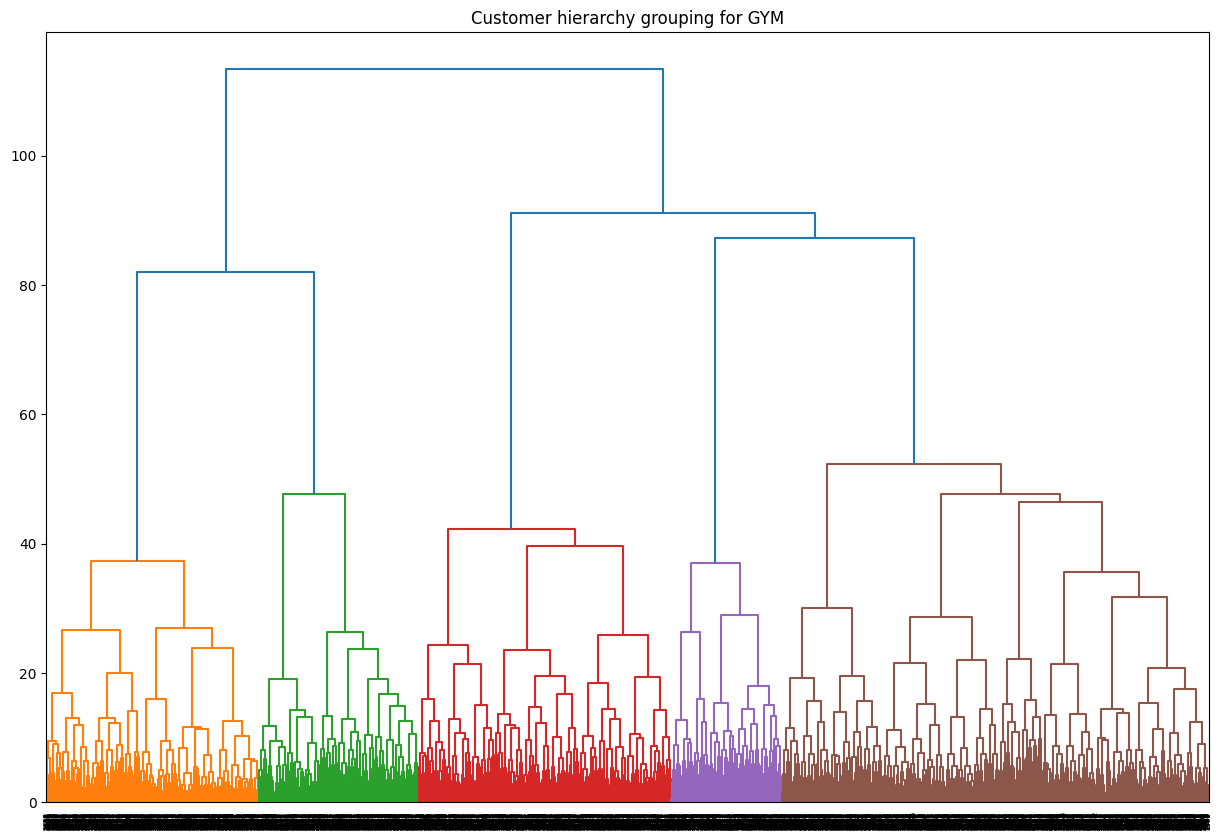

In [23]:
# dendogram tracing
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Customer hierarchy grouping for GYM')
plt.show()

In [24]:
#K-means model creation
km = KMeans(n_clusters = 5, random_state=0) # establecer el número de clústeres en 5
labels = km.fit_predict(sc_data)

In [25]:
print(labels.size)

4000


In [27]:
#addition of classification to user information
data['class']=labels

In [28]:
user_type_mean=data.groupby('class').mean().reset_index()
print(user_type_mean)

   class    gender  Near_Location   Partner  Promo_friends     Phone  \
0      0  0.475694       0.825231  0.446759       0.252315  1.000000   
1      1  0.549645       0.842790  0.374704       0.216312  0.998818   
2      2  0.507447       0.760638  0.341489       0.179787  0.997872   
3      3  0.503619       0.938987  0.768356       0.564633  1.000000   
4      4  0.524804       0.866841  0.469974       0.308094  0.000000   

   Contract_period  Group_visits        Age  Avg_additional_charges_total  \
0         2.643519      0.380787  30.021991                    153.404553   
1         2.750591      0.442080  29.977541                    160.245842   
2         1.567021      0.257447  26.908511                    115.109065   
3        11.168563      0.558428  29.895553                    161.582993   
4         4.806789      0.428198  29.331593                    144.156967   

   Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
0               2.461806  4.671296     

Looking at the mean value of each feature for every gym-user cluster, we find that clusters 0 and 2 are the most likely to leave the gym. Within those two, cluster 0 has an average location value of 0, while cluster 2 has location 1; both clusters also show a shorter average lifetime than the others.

Cluster 1 exhibits the highest averages for the partner, promo friends, and contract period features. This group probably corresponds to users who work out with friends and make use of group perks.

Cluster 4 consists of users very similar to cluster 1, but they attend fewer classes than the rest—perhaps they prefer exercising at their own pace.

Finally, cluster 3 contains users who show a strong interest in classes, yet they do not seem to take advantage of friend or partner promotions and generally hold short-term contracts.

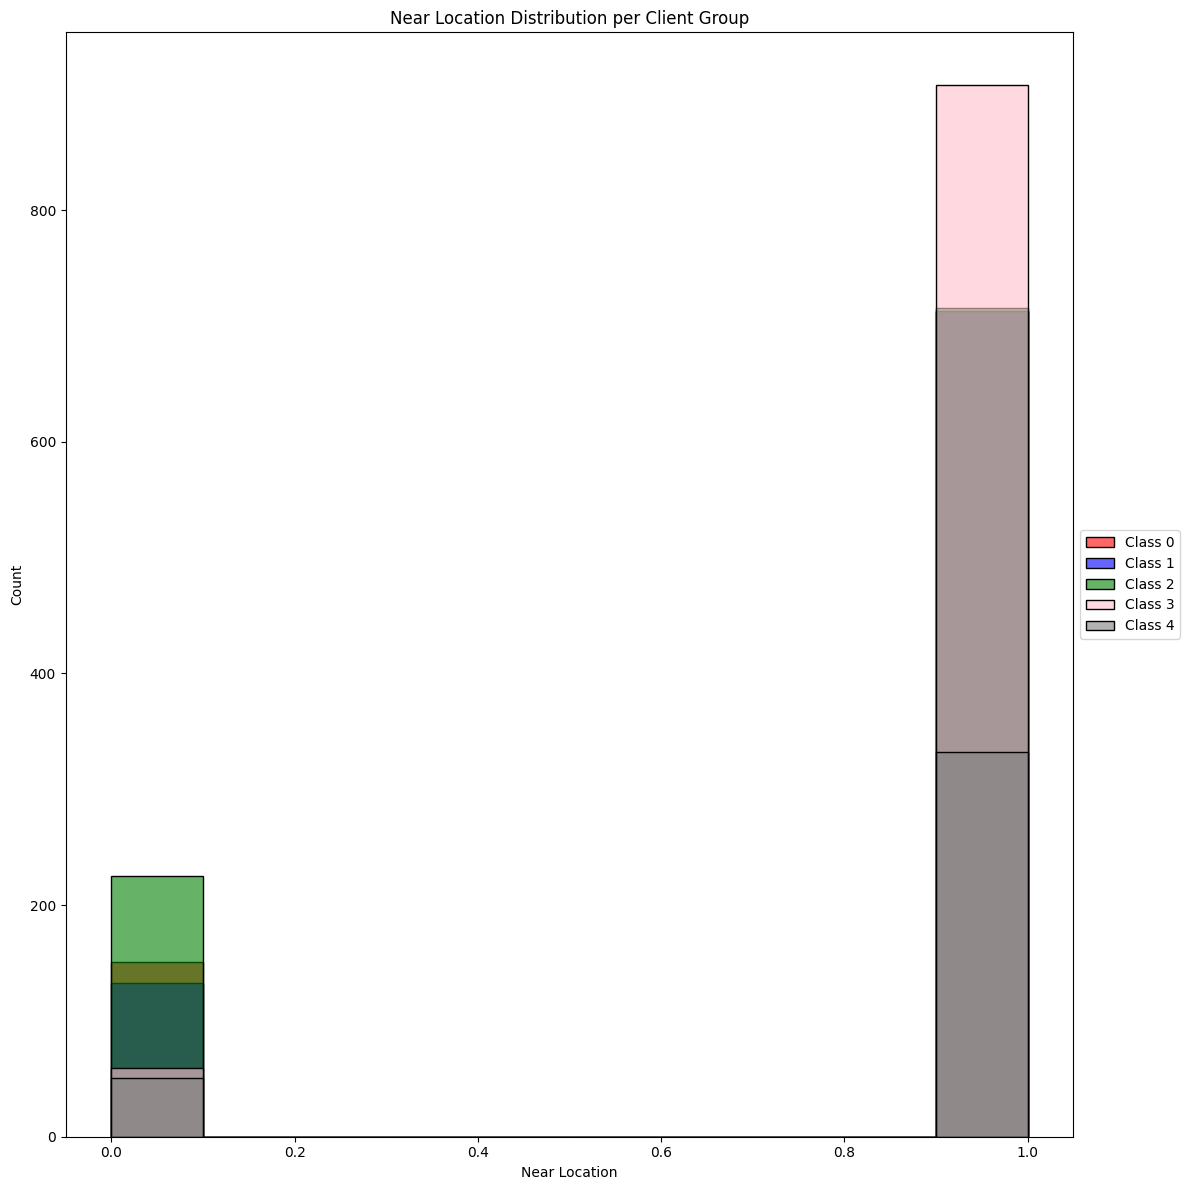

In [29]:
#characteristic distribution per cluster

i=0
colors=['red','blue','green','pink','gray']

plt.figure(figsize=(12,12))

# Loop through each class
for i in range(5):
    subset = data[data['class'] == i]
    
    sns.histplot(
        subset['Near_Location'],
        kde=False,
        bins=10,
        color=colors[i],
        label=f'Class {i}',
        alpha=0.6
    )

# Customize the plot
plt.title('Near Location Distribution per Client Group')
plt.xlabel('Near Location')
plt.ylabel('Count')

# Legend outside the plot (to the right)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout
plt.tight_layout()
plt.show()

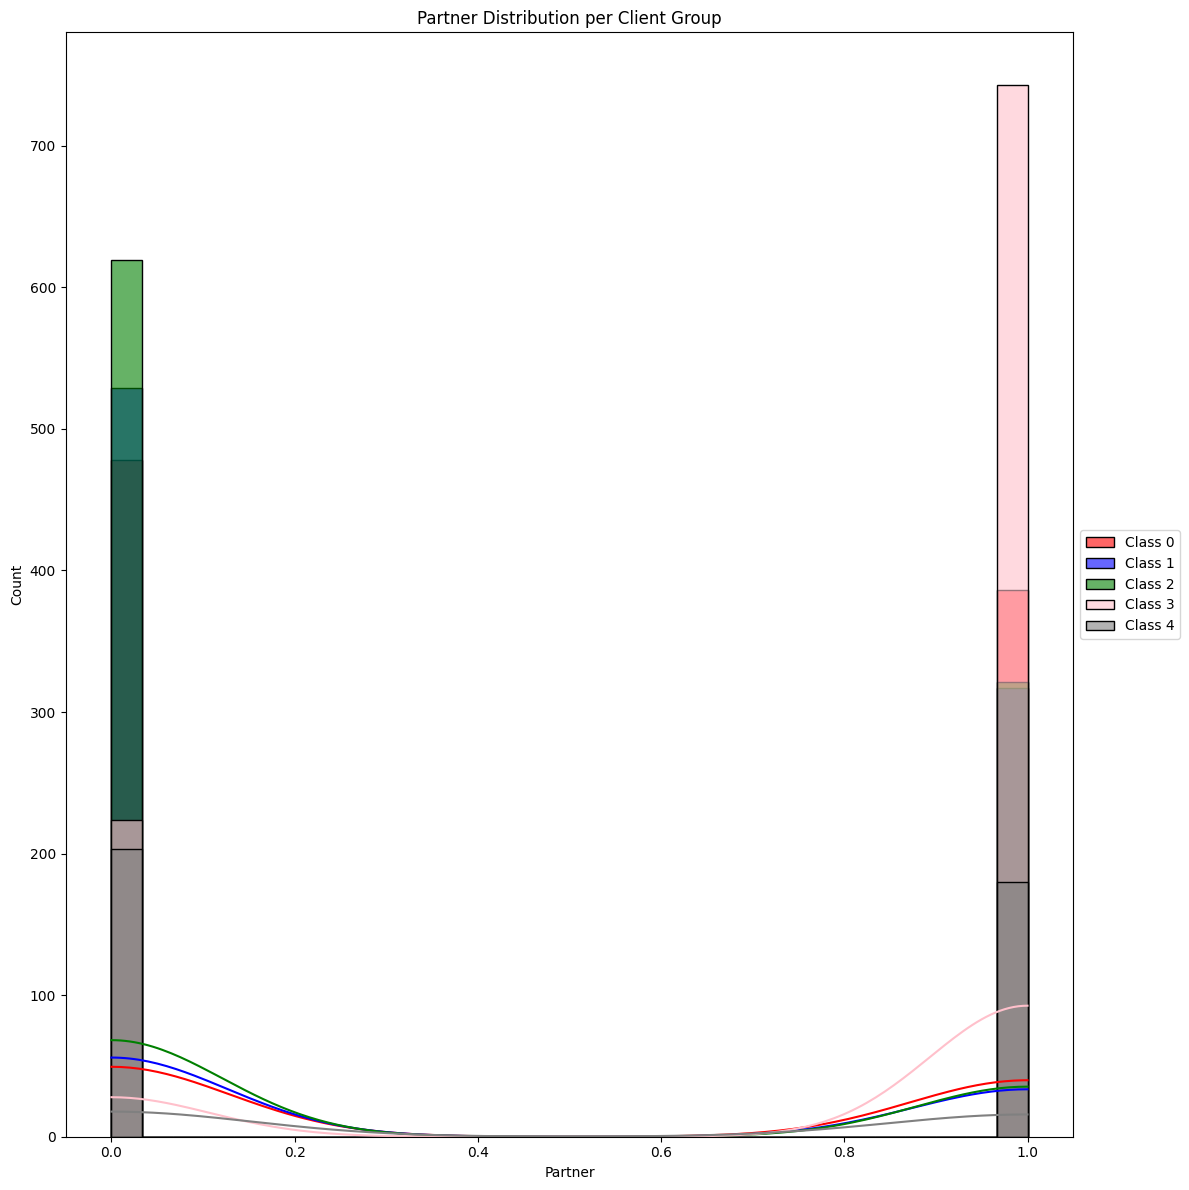

In [30]:
i=0
colors=['red','blue','green','pink','gray']

plt.figure(figsize=(12,12))

# Loop through each class
for i in range(5):
    subset = data[data['class'] == i]
    
    sns.histplot(
        subset['Partner'],
        kde=True,
        bins=30,
        color=colors[i],
        label=f'Class {i}',
        alpha=0.6
    )

# Customize the plot
plt.title('Partner Distribution per Client Group')
plt.xlabel('Partner')
plt.ylabel('Count')

# Legend outside the plot (to the right)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout
plt.tight_layout()
plt.show()

To ease the visluatization of binary characteristics these will be plotted in a box plot diagram

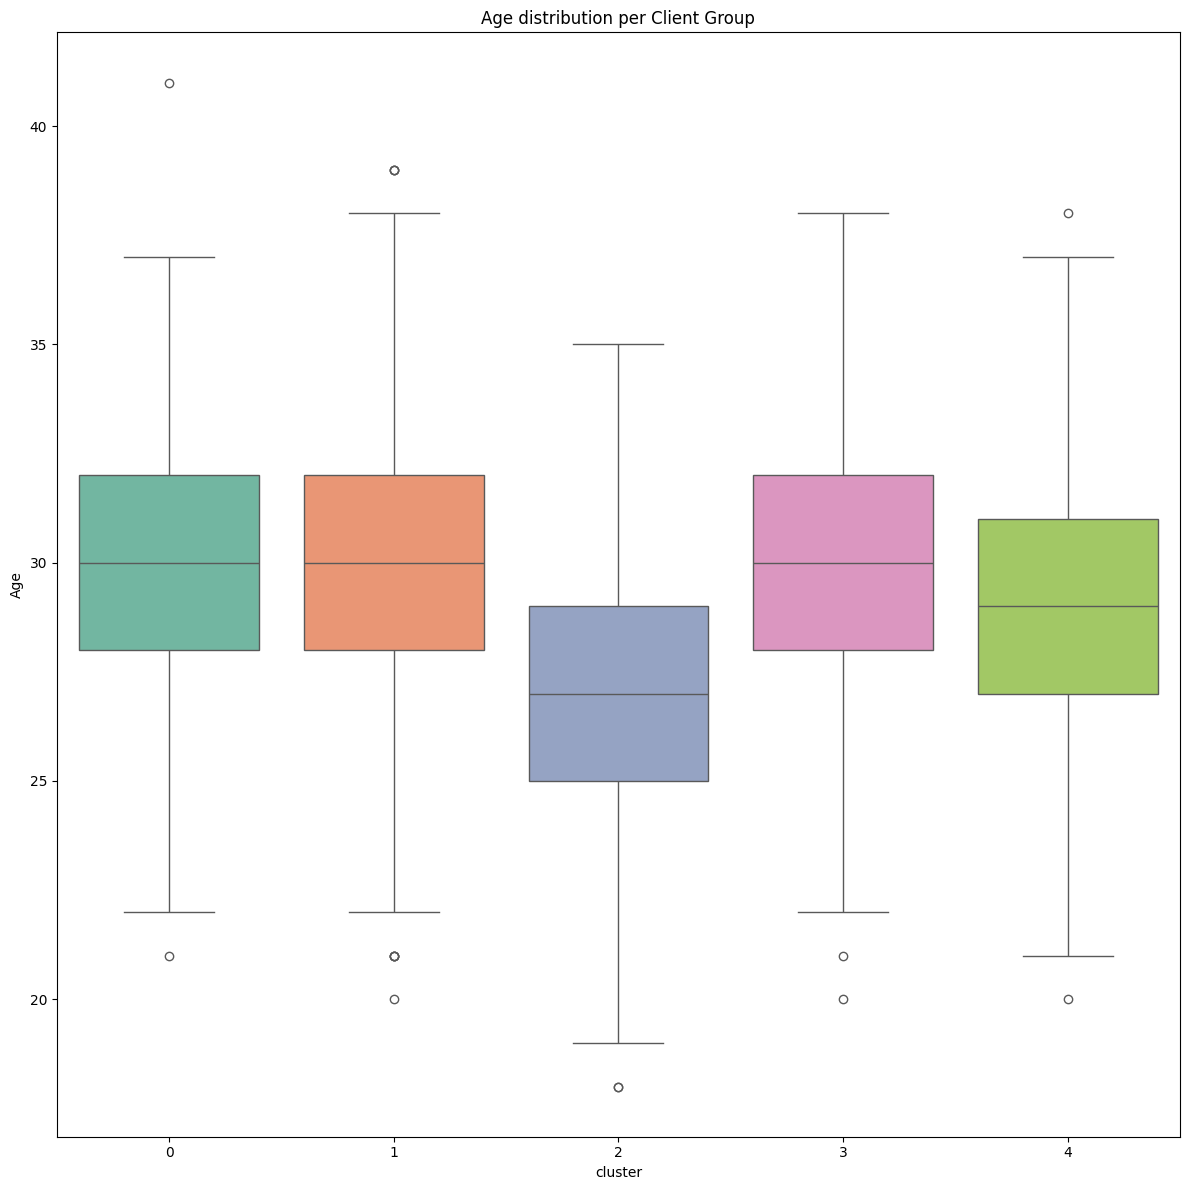

In [40]:
i=0
colors=['red','blue','green','pink','gray']

plt.figure(figsize=(12,12))

# Loop through each class
for i in range(5):
    subset = data[data['class'] == i]
    


sns.boxplot(data=data, x='class', y='Age', hue='class', palette='Set2', legend=False)

# Customize the plot
plt.title('Age distribution per Client Group')
plt.xlabel('cluster')
plt.ylabel('Age')

# Legend outside the plot (to the right)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout
plt.tight_layout()
plt.show()

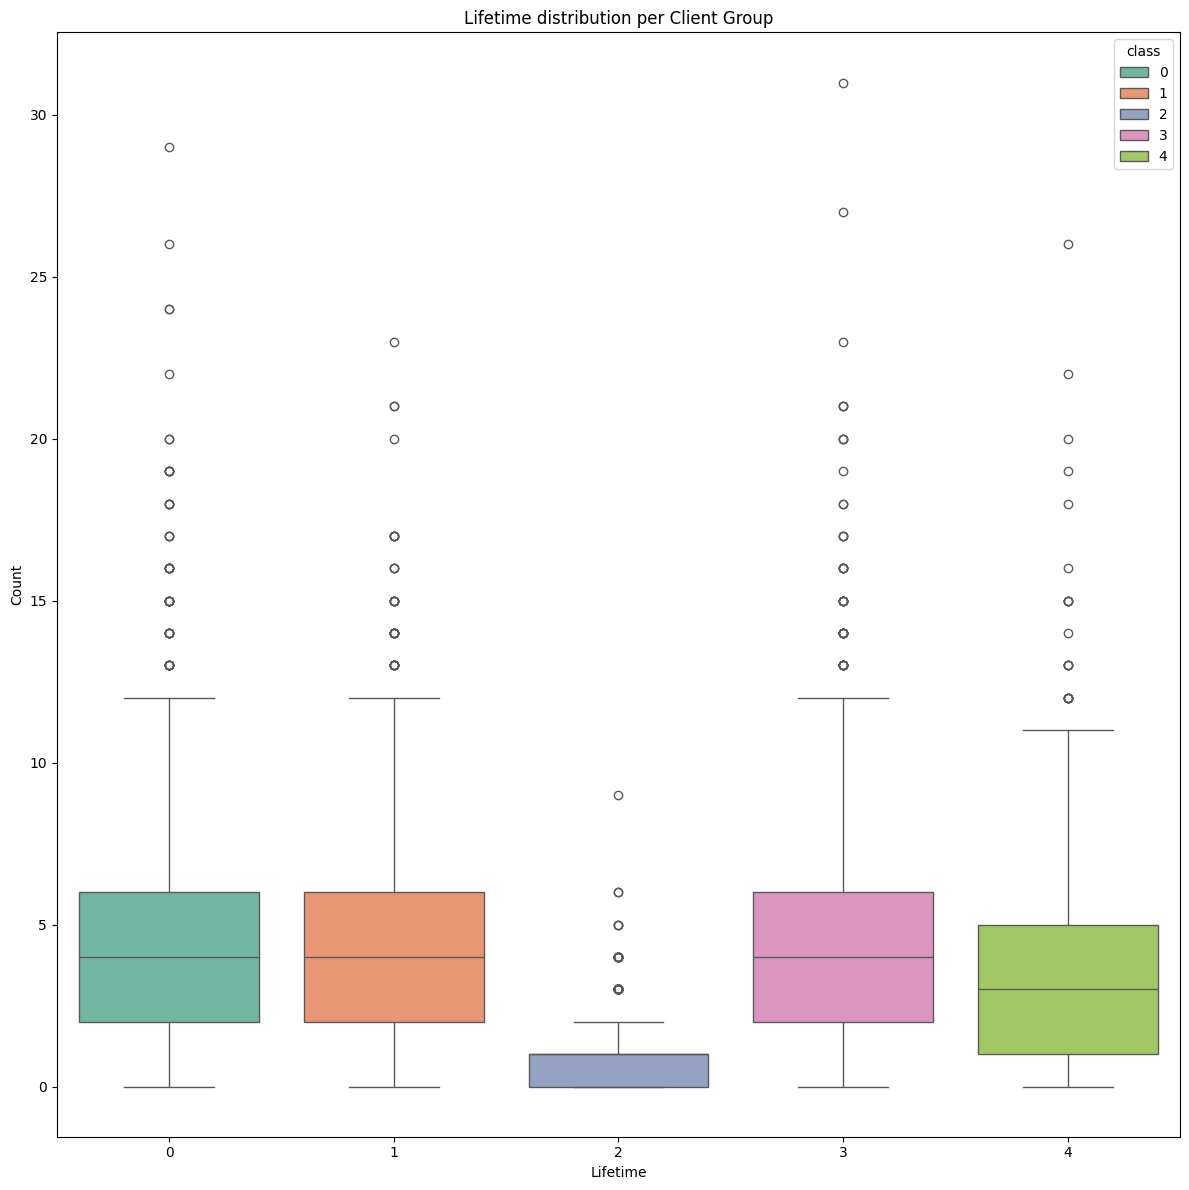

In [43]:
i=0
colors=['red','blue','green','pink','gray']

plt.figure(figsize=(12,12))

# Loop through each class
for i in range(5):
    subset = data[data['class'] == i]
    
sns.boxplot(
    data=data,
    x='class',
    y='Lifetime', hue='class',
    palette='Set2'  # Optional: nice color palette
)

# Customize the plot
plt.title('Lifetime distribution per Client Group')
plt.xlabel('Lifetime')
plt.ylabel('Count')

# Legend outside the plot (to the right)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout
plt.tight_layout()
plt.show()

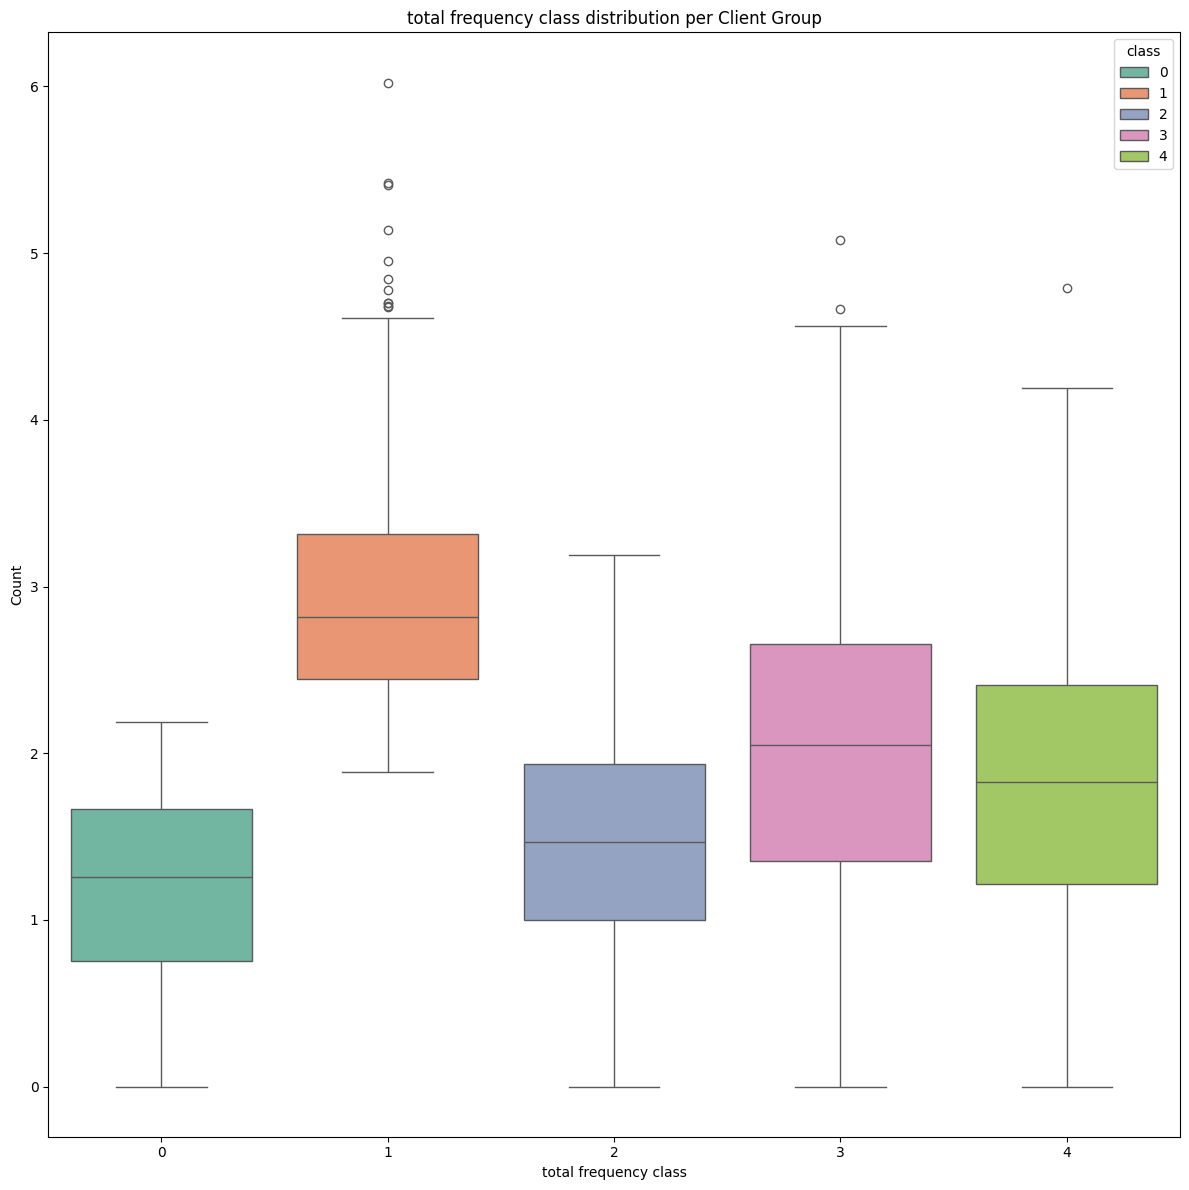

In [44]:
i=0
colors=['red','blue','green','pink','gray']

plt.figure(figsize=(12,12))

# Loop through each class
for i in range(5):
    subset = data[data['class'] == i]
    
sns.boxplot(
    data=data,
    x='class',
    y='Avg_class_frequency_total', hue='class',
    palette='Set2'  # Optional: nice color palette
)

# Customize the plot
plt.title('total frequency class distribution per Client Group')
plt.xlabel('total frequency class')
plt.ylabel('Count')

# Legend outside the plot (to the right)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout
plt.tight_layout()
plt.show()

The charts provide a visual summary of the mean value of each feature for every user class. They also reveal that class 2 is, on average, younger than the other classes. Although an A/B test suggests that the overall distributions of the user classes are not statistically different, the clusters do differ in certain specific features that the clustering model was able to detect.

<h2>Conclusions </h2>

<p>
  A clustering model produced <strong>five user groups</strong> based on the selected features.
  These groups were then fed into a K-Means model, which assigned a label to every user
  and regrouped them accordingly. By inspecting each cluster in detail we could pinpoint
  the distinguishing values the algorithm likely relied on to form the groups.
</p>

<ul>
  <li>
    <strong>Clusters&nbsp;0 and&nbsp;2 show the highest subscription-cancellation rates.</strong>
    <ul>
      <li>
        Cluster&nbsp;2 members make the least use of membership benefits—group visits,
        friend-or-partner promotions—and they are the youngest segment.
      </li>
      <li>
        For Cluster&nbsp;0, the main differentiator is <strong>location</strong>, which seems
        to limit participation in group activities and access to friend/partner perks; the
        result is reduced benefit usage and, eventually, churn. Even so, their dropout
        rate is not quite as high as that of Cluster&nbsp;2.
      </li>
    </ul>
  </li>

  <li>
    <strong>Clusters&nbsp;1, 3, and&nbsp;4 score highest</strong> in group-class attendance,
    multi-month contract purchases, spending on add-on services, and uptake of
    partner/friend benefits.
    <ul>
      <li>Label&nbsp;1 users engage in virtually all available activities.</li>
      <li>Cluster&nbsp;3 users focus most heavily on classes.</li>
      <li>Label&nbsp;4 users appear more interested in personalised workouts with friends or partners than in group classes.</li>
    </ul>
  </li>
</ul>

<p>
  Overall, <strong>retention is strongly tied to access to benefits</strong>, and the
  probability of churn falls once a member has been subscribed for a certain length
  of time. We therefore recommend:
</p>

<ol>
  <li>Improving communication about membership perks.</li>
  <li>Investigating why some users cannot access those benefits.</li>
  <li>Encouraging the purchase of longer-term contracts.</li>
</ol>